### オートーエンコーダの演習

#### 使い方

* 特徴抽出
* 特徴でさらに学習 ( fine-tuning )
* 画像生成

#### 課題

1. コードを動かしてみて、下記の質問に答えよう

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import random
from tqdm import tqdm

#### モデルの定義

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, fan_in, fan_out, kernel=3, stride=1, padding=1, upscale=None):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d( fan_in, fan_out, kernel_size=kernel, stride=stride, padding=padding )
        self.bn   = nn.BatchNorm2d( fan_out ) # 標準偏差をなくす。 標準化 勾配消失が発生しづらく
        self.upscale = upscale
        
    def forward(self, x):
        if self.upscale != None:
            x = F.interpolate( x, scale_factor=self.upscale, mode='bilinear', align_corners=False)
        return F.relu( self.bn( self.conv(x) ) )

In [0]:
class Net(nn.Module):
    def __init__(self, bottleneck=128):
        super(Net, self).__init__()
        self.bottleneck = bottleneck
        self.encoder = nn.ModuleList([
            ConvLayer(   1,  32, stride=2 ), # 14
            ConvLayer(  32,  64, stride=2 ), # 7
            ConvLayer(  64,  64, stride=2 ), # 4
            ConvLayer(  64,  self.bottleneck, kernel=4, padding=0 ),
        ])
        self.decoder = nn.ModuleList([
            ConvLayer( self.bottleneck,  64, upscale=7. ), # 7
            ConvLayer(  64,  32, upscale=2. ), # 14
            ConvLayer(  32,  32, upscale=2. ), # 28
            ConvLayer(  32,  16 )
        ])
        self.last = nn.Conv2d( 16, 1, 3, stride=1, padding=1 )

    def encode(self, x):
        for e in self.encoder:
            x = e(x)
        return x
    def decode(self, x):
        for d in self.decoder:
            x = d(x)
        return torch.sigmoid( self.last(x) )
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)

#### データ

In [0]:
Dtrain = datasets.MNIST('../data', train=True, download=True )
Dtest  = datasets.MNIST('../data', train=False, download=True )

In [0]:
Dmean = torch.tensor( list( map( lambda x: transforms.ToTensor()(x[0]).mean(), Dtrain ) ) ).mean()
Dstd = torch.tensor( list( map( lambda x: transforms.ToTensor()(x[0]).std(), Dtrain ) ) ).mean()
print( "Data: %.3f (%.3f)" % (Dmean, Dstd))

Data: 0.131 (0.302)


In [0]:
idx = list(range(len(Dtrain)))
random.shuffle(idx)
idx = idx[0:10000]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx)

Dtransform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((Dmean,), (Dstd,))] )
Dtrain = datasets.MNIST('../data', train=True,  transform=Dtransform )
Dtest  = datasets.MNIST('../data', train=False, transform=Dtransform )

batchsize = 64
train_loader = torch.utils.data.DataLoader( Dtrain, batch_size=batchsize, sampler=train_sampler )
test_loader  = torch.utils.data.DataLoader( Dtest,  batch_size=batchsize )

#### モデル、ロス関数、最適化手法

In [0]:
device = torch.device("cuda" if torch.cuda.device_count()>0 else "cpu")
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

#### 学習ループ

In [0]:
epoch_train_loss = []
epoch_valid_loss = []

In [0]:
for epoch in range(10):    
    model.train()
    running_loss = 0
    for x,y in tqdm(train_loader, desc=("Epoch %d"%(epoch+1))):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = torch.pow(pred-x, 2).mean()
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    epoch_train_loss.append( running_loss/len(train_loader) )

Epoch 10: 100%|██████████| 157/157 [00:28<00:00,  5.47it/s]


#### プロット

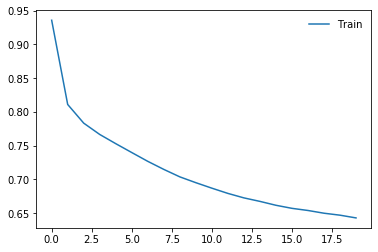

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot( epoch_train_loss, label='Train')
plt.legend(frameon=False)

#### テスト

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


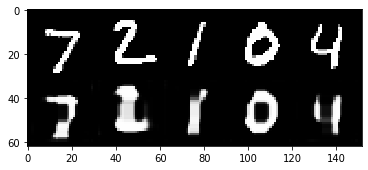

In [0]:
import torchvision
model.eval()
I = torch.zeros(10,1,28,28)
for i in range(5):
    x = Dtest[i][0].unsqueeze(0).to(device)
    pred = model(x).detach()
    I[i,:,:,:] = x
    I[5+i,:,:,:] = pred.to('cpu')
I = torchvision.utils.make_grid( I, nrow=5 )
plt.imshow(I.permute(1, 2, 0))

#### オートエンコーダでの特徴抽出

In [0]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc = nn.Linear(128, 10)
    def forward(self, x):
        return F.log_softmax( self.fc(x), dim=1)
linear = LinearNet().to(device)
optimizerL = torch.optim.SGD(linear.parameters(), lr=0.001, momentum=0.5)

In [0]:
epoch_train_lossL = []
for epoch in range(10):
    model.train()
    running_loss = 0
    for x,y in tqdm(train_loader, desc=("Epoch %d"%(epoch+1))):
        optimizerL.zero_grad()
        x, y = x.to(device), y.to(device)
        f = model.encode(x).detach()
        
        pred = linear(f.view(-1,128))
        loss = F.nll_loss( pred, y )
        running_loss += loss.item()
        
        loss.backward()
        optimizerL.step()
    epoch_train_lossL.append( running_loss/len(train_loader) )

Epoch 10: 100%|██████████| 157/157 [00:05<00:00, 30.80it/s]


In [0]:
model.eval()
with torch.no_grad():
    correct = 0
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        f = model.encode(x)
        pred = linear(f.view(-1,128)).argmax( dim=1, keepdim=True )
        correct += pred.eq( y.view_as(pred) ).sum().item()
print( correct / len(test_loader.dataset) )

0.8011


#### 偽物を作る

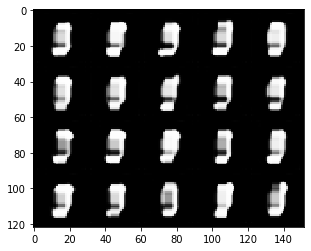

In [0]:
x = torch.rand(20,128,1,1).to(device)
I = model.decode(x).detach()
I = torchvision.utils.make_grid( I, nrow=5 )
plt.imshow(I.permute(1, 2, 0).to('cpu'))

### 質問

1. bottleneckはどの影響を与える？
1. LinearNetの学習はどうやって早くできる？
1. dropoutを特徴にかけるとどうなる？なぜ？
1. MNISTで学習済みのオートエンコーダの特徴を他のデータセットで使うとどうなる？（参考： https://pytorch.org/docs/stable/torchvision/datasets.html#kmnist )
1. オートエンコーダの再現性能と特徴の性能の関係がある？